In [16]:
# Check if running in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IN_COLAB}")

# Install required packages if in Colab environment
if IN_COLAB:
    print("Installing required Python packages...")
    !pip install torch torchvision scikit-learn matplotlib seaborn tqdm
    !pip install scipy  # For loading MATLAB files
    print("Packages installed successfully.")

# Import necessary libraries for model development, training, and evaluation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import os
import json
import urllib.request
import tarfile
import shutil
from pathlib import Path
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

# Set up working directories for data and model saving
WORK_DIR = Path('/content/drive/MyDrive/flower_recognition')
DATA_DIR = WORK_DIR / 'oxford_flowers'
WORK_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
print(f"Working directory set to: {WORK_DIR}")
print(f"Data directory set to: {DATA_DIR}")

# Check for GPU availability and set the device for computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Running in Google Colab: True
Installing required Python packages...
Packages installed successfully.
Working directory set to: /content/drive/MyDrive/flower_recognition
Data directory set to: /content/drive/MyDrive/flower_recognition/oxford_flowers

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB


In [17]:
# Import necessary components from torchvision for dataset loading and transformations
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision import transforms

In [18]:
def get_transforms():
    # Normalization parameters based on ImageNet statistics
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # Training transformations including data augmentation
    train_transform = transforms.Compose([
        transforms.Resize(256),            # Resize images to 256 pixels
        transforms.RandomCrop(224),        # Randomly crop to 224x224
        transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
        transforms.RandomRotation(15),     # Randomly rotate images by up to 15 degrees
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1), # Randomly change brightness, contrast, saturation, and hue
        transforms.ToTensor(),             # Convert PIL Image to PyTorch Tensor
        normalize                          # Normalize pixel values
    ])

    # Validation/test transformations (no data augmentation)
    val_transform = transforms.Compose([
        transforms.Resize(256),   # Resize images to 256 pixels
        transforms.CenterCrop(224), # Crop the center to 224x224
        transforms.ToTensor(),    # Convert PIL Image to PyTorch Tensor
        normalize                 # Normalize pixel values
    ])

    return train_transform, val_transform

In [19]:
# Get the defined image transformation pipelines
train_transform, val_transform = get_transforms()

print("Loading Flowers102 datasets...")
# Initialize the training dataset with augmentation transforms
train_dataset = Flowers102(
    root=DATA_DIR,        # Root directory where dataset is stored/downloaded
    split="train",        # Specify the training split
    transform=train_transform, # Apply training transformations
    download=True         # Download the dataset if not already present
)

# Initialize the validation dataset with evaluation transforms
val_dataset = Flowers102(
    root=DATA_DIR,        # Root directory where dataset is stored/downloaded
    split="val",          # Specify the validation split
    transform=val_transform,   # Apply validation transformations
    download=True         # Download the dataset if not already present
)

# Initialize the test dataset with evaluation transforms
test_dataset = Flowers102(
    root=DATA_DIR,        # Root directory where dataset is stored/downloaded
    split="test",         # Specify the test split
    transform=val_transform,   # Apply test transformations
    download=True         # Download the dataset if not already present
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print("Datasets loaded successfully.")

Loading Flowers102 datasets...
Train dataset size: 1020
Validation dataset size: 1020
Test dataset size: 6149
Datasets loaded successfully.


In [20]:
# Define batch size for DataLoader
batch_size = 32
# Set number of workers for data loading, optimize for Colab environment
num_workers = 2 if IN_COLAB else 4

print(f"Initializing DataLoaders with batch size: {batch_size} and {num_workers} workers...")

# Create DataLoader for the training dataset
train_loader = DataLoader(
    train_dataset,          # Training dataset
    batch_size=batch_size,  # Number of samples per batch
    shuffle=True,           # Shuffle data for training
    num_workers=num_workers,# Number of subprocesses to use for data loading
    pin_memory=True         # Pin memory for faster GPU transfer
)

# Create DataLoader for the validation dataset
val_loader = DataLoader(
    val_dataset,            # Validation dataset
    batch_size=batch_size,  # Number of samples per batch
    shuffle=False,          # Do not shuffle validation data
    num_workers=num_workers,# Number of subprocesses to use for data loading
    pin_memory=True         # Pin memory for faster GPU transfer
)

# Create DataLoader for the test dataset
test_loader = DataLoader(
    test_dataset,           # Test dataset
    batch_size=batch_size,  # Number of samples per batch
    shuffle=False,          # Do not shuffle test data
    num_workers=num_workers,# Number of subprocesses to use for data loading
    pin_memory=True         # Pin memory for faster GPU transfer
)

print("DataLoaders initialized.")

Initializing DataLoaders with batch size: 32 and 2 workers...
DataLoaders initialized.


In [21]:
# Retrieve the class names from the training dataset
class_names = train_dataset.classes
print(f"No. of flower classes: {len(class_names)}")  # Should be 102 for Flowers102 dataset

No. of flower classes: 102


In [22]:
# Define the EfficientNet-B0 model for flower classification
class FlowerClassifier(nn.Module):
    """Transfer learning model for flower classification using EfficientNet-B0 as backbone."""

    def __init__(self, num_classes=102, pretrained=True):
        super(FlowerClassifier, self).__init__()

        # Load a pretrained EfficientNet-B0 model from torchvision
        self.backbone = models.efficientnet_b0(pretrained=pretrained)

        # Get the number of input features to the original classifier layer
        in_features = self.backbone.classifier[1].in_features

        # Replace the original classifier with a custom head for our specific task
        # This custom head includes Dropout layers for regularization and a ReLU activation
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True), # Dropout for regularization
            nn.Linear(in_features, 512),     # First fully connected layer
            nn.ReLU(inplace=True),           # ReLU activation function
            nn.Dropout(p=0.3),               # Another dropout layer
            nn.Linear(512, num_classes)      # Output layer with 'num_classes' neurons
        )

        # Initialize the weights of the newly added layers
        self._initialize_weights()

    def _initialize_weights(self):
        """Initializes weights for the new classifier layers using Kaiming normal initialization."""
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear): # Apply to linear layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0) # Initialize biases to zero

    def forward(self, x):
        """Defines the forward pass of the model."""
        return self.backbone(x)

# Create an instance of the FlowerClassifier model
print("Initializing FlowerClassifier model...")
model = FlowerClassifier(num_classes=102, pretrained=True)
model = model.to(device) # Move the model to the specified device (GPU if available)
print("Model initialized and moved to device.")

# Print model summary to show parameter count and size
total_params = sum(p.numel() for p in model.parameters()) # Total number of parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # Number of trainable parameters
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.1f} MB (assuming float32 parameters)")

Initializing FlowerClassifier model...
Model initialized and moved to device.

Total parameters: 4,715,746
Trainable parameters: 4,715,746
Model size: 18.0 MB (assuming float32 parameters)


In [23]:
# --- Training setup ---
# Define the loss function: Cross-Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer: Adam optimizer with a learning rate and weight decay
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the learning rate scheduler: ReduceLROnPlateau
# It will reduce the learning rate when a metric (validation accuracy) has stopped improving.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,              # Optimizer to adjust learning rate
    mode='max',             # Monitor a metric that should be maximized (e.g., accuracy)
    factor=0.5,             # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3              # Number of epochs with no improvement after which learning rate will be reduced
)

# --- Training parameters ---
num_epochs = 30           # Total number of training epochs
best_val_acc = 0.0        # Variable to keep track of the best validation accuracy achieved
best_epoch = 0            # Epoch at which the best validation accuracy was achieved

# Initialize dictionary to store training history (loss, accuracy, learning rates)
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

print(f"Training setup complete!")
print(f"Device: {device}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Learning rate scheduler: {scheduler.__class__.__name__}")

Training setup complete!
Device: cuda
Number of epochs: 30
Batch size: 32
Optimizer: Adam
Loss function: CrossEntropyLoss
Learning rate scheduler: ReduceLROnPlateau


In [24]:
# --- Main Training Loop ---
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 50)

    # --- Training Phase ---
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Use tqdm for a progress bar during training
    train_pbar = tqdm(train_loader, desc="Training")
    for batch_idx, (data, targets) in enumerate(train_pbar):
        data, targets = data.to(device), targets.to(device) # Move data and labels to the device

        optimizer.zero_grad()  # Zero the gradients before running the backward pass
        outputs = model(data)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, targets) # Calculate the batch loss
        loss.backward()        # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()       # Perform a single optimization step (parameter update)

        train_loss += loss.item() # Accumulate training loss
        # Get the predicted class from the model outputs
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0) # Update total number of samples
        train_correct += (predicted == targets).sum().item() # Update number of correctly predicted samples

        # Update progress bar with current loss and accuracy
        current_acc = 100. * train_correct / train_total
        train_pbar.set_postfix({
          'Loss': f'{train_loss / (train_pbar.n + 1):.4f}',
          'Acc': f'{current_acc:.2f}%'
      })

    # Calculate average training loss and accuracy for the epoch
    train_loss_avg = train_loss / len(train_loader)
    train_acc_avg = 100. * train_correct / train_total

    # --- Validation Phase ---
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation, saves memory and computations
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc="Validation")
        for data, targets in val_pbar:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            val_loss += loss.item() # Accumulate validation loss
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

            # Update progress bar with current loss and accuracy
            current_acc = 100. * val_correct / val_total
            val_pbar.set_postfix({
              'Loss': f'{val_loss / (val_pbar.n + 1):.4f}',
              'Acc': f'{current_acc:.2f}%'
          })

    # Calculate average validation loss and accuracy for the epoch
    val_loss_avg = val_loss / len(val_loader)
    val_acc_avg = 100. * val_correct / val_total

    # --- Learning Rate Scheduling ---
    # Step the learning rate scheduler based on validation accuracy
    scheduler.step(val_acc_avg)
    current_lr = optimizer.param_groups[0]['lr'] # Get the current learning rate

    # --- Update Training History ---
    history['train_loss'].append(train_loss_avg)
    history['train_acc'].append(train_acc_avg)
    history['val_loss'].append(val_loss_avg)
    history['val_acc'].append(val_acc_avg)
    history['learning_rates'].append(current_lr)

    # --- Print Epoch Results ---
    print(f"Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc_avg:.2f}%")
    print(f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc_avg:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")

    # --- Save Best Model ---
    # If current validation accuracy is better than the best recorded, save the model checkpoint
    if val_acc_avg > best_val_acc:
        best_val_acc = val_acc_avg
        best_epoch = epoch + 1

        # Save model state, optimizer state, and training metrics
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'epoch': epoch + 1,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc_avg,
            'val_loss': val_loss_avg,
            'train_acc': train_acc_avg,
            'train_loss': train_loss_avg
        }

        torch.save(checkpoint, os.path.join(WORK_DIR, 'best_model.pth'))
        print(f"New best model saved! Val Acc: {val_acc_avg:.2f}%")

print(f"\nTraining completed!")
print(f"Best validation accuracy achieved: {best_val_acc:.2f}% (at Epoch {best_epoch})")


Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s, Loss=3.0343, Acc=33.14%]


Train Loss: 5.0951, Train Acc: 5.69%
Val Loss: 3.0343, Val Acc: 33.14%
Learning Rate: 0.001000
New best model saved! Val Acc: 33.14%

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s, Loss=1.6288, Acc=59.22%]


Train Loss: 2.8313, Train Acc: 33.43%
Val Loss: 1.6288, Val Acc: 59.22%
Learning Rate: 0.001000
New best model saved! Val Acc: 59.22%

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.31it/s, Loss=0.9367, Acc=74.90%]


Train Loss: 1.6245, Train Acc: 56.27%
Val Loss: 0.9367, Val Acc: 74.90%
Learning Rate: 0.001000
New best model saved! Val Acc: 74.90%

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.31it/s, Loss=0.9453, Acc=76.18%]


Train Loss: 0.9606, Train Acc: 74.12%
Val Loss: 0.9453, Val Acc: 76.18%
Learning Rate: 0.001000
New best model saved! Val Acc: 76.18%

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.07it/s, Loss=0.8892, Acc=78.92%]


Train Loss: 0.6591, Train Acc: 81.18%
Val Loss: 0.8892, Val Acc: 78.92%
Learning Rate: 0.001000
New best model saved! Val Acc: 78.92%

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s, Loss=0.7261, Acc=82.65%]


Train Loss: 0.5574, Train Acc: 83.92%
Val Loss: 0.7261, Val Acc: 82.65%
Learning Rate: 0.001000
New best model saved! Val Acc: 82.65%

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s, Loss=0.7844, Acc=81.08%]


Train Loss: 0.4231, Train Acc: 87.35%
Val Loss: 0.7844, Val Acc: 81.08%
Learning Rate: 0.001000

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s, Loss=0.8291, Acc=80.59%]


Train Loss: 0.3810, Train Acc: 89.71%
Val Loss: 0.8291, Val Acc: 80.59%
Learning Rate: 0.001000

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s, Loss=0.7023, Acc=82.55%]


Train Loss: 0.3978, Train Acc: 89.22%
Val Loss: 0.7023, Val Acc: 82.55%
Learning Rate: 0.001000

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s, Loss=0.7402, Acc=83.63%]


Train Loss: 0.3108, Train Acc: 91.47%
Val Loss: 0.7402, Val Acc: 83.63%
Learning Rate: 0.001000
New best model saved! Val Acc: 83.63%

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s, Loss=0.6807, Acc=86.08%]


Train Loss: 0.2358, Train Acc: 92.35%
Val Loss: 0.6807, Val Acc: 86.08%
Learning Rate: 0.001000
New best model saved! Val Acc: 86.08%

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s, Loss=0.8352, Acc=80.49%]


Train Loss: 0.2839, Train Acc: 92.35%
Val Loss: 0.8352, Val Acc: 80.49%
Learning Rate: 0.001000

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s, Loss=0.6594, Acc=85.49%]


Train Loss: 0.2194, Train Acc: 94.02%
Val Loss: 0.6594, Val Acc: 85.49%
Learning Rate: 0.001000

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s, Loss=0.7868, Acc=82.94%]


Train Loss: 0.2269, Train Acc: 94.02%
Val Loss: 0.7868, Val Acc: 82.94%
Learning Rate: 0.001000

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s, Loss=0.6728, Acc=85.59%]


Train Loss: 0.1446, Train Acc: 95.20%
Val Loss: 0.6728, Val Acc: 85.59%
Learning Rate: 0.000500

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s, Loss=0.5836, Acc=87.94%]


Train Loss: 0.1460, Train Acc: 96.18%
Val Loss: 0.5654, Val Acc: 87.94%
Learning Rate: 0.000500
New best model saved! Val Acc: 87.94%

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s, Loss=0.5580, Acc=88.73%]


Train Loss: 0.0999, Train Acc: 96.67%
Val Loss: 0.5580, Val Acc: 88.73%
Learning Rate: 0.000500
New best model saved! Val Acc: 88.73%

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s, Loss=0.5774, Acc=89.02%]


Train Loss: 0.1119, Train Acc: 97.25%
Val Loss: 0.5774, Val Acc: 89.02%
Learning Rate: 0.000500
New best model saved! Val Acc: 89.02%

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s, Loss=0.5363, Acc=88.92%]


Train Loss: 0.0771, Train Acc: 98.33%
Val Loss: 0.5363, Val Acc: 88.92%
Learning Rate: 0.000500

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s, Loss=0.5531, Acc=88.73%]


Train Loss: 0.0521, Train Acc: 98.53%
Val Loss: 0.5531, Val Acc: 88.73%
Learning Rate: 0.000500

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s, Loss=0.5354, Acc=89.71%]


Train Loss: 0.0373, Train Acc: 98.73%
Val Loss: 0.5354, Val Acc: 89.71%
Learning Rate: 0.000500
New best model saved! Val Acc: 89.71%

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s, Loss=0.5703, Acc=88.73%]


Train Loss: 0.0796, Train Acc: 97.25%
Val Loss: 0.5703, Val Acc: 88.73%
Learning Rate: 0.000500

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s, Loss=0.5265, Acc=89.71%]


Train Loss: 0.0373, Train Acc: 98.73%
Val Loss: 0.5265, Val Acc: 89.71%
Learning Rate: 0.000500

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s, Loss=0.5268, Acc=88.63%]


Train Loss: 0.0505, Train Acc: 98.82%
Val Loss: 0.5268, Val Acc: 88.63%
Learning Rate: 0.000500

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s, Loss=0.5118, Acc=90.00%]


Train Loss: 0.0314, Train Acc: 98.92%
Val Loss: 0.5118, Val Acc: 90.00%
Learning Rate: 0.000500
New best model saved! Val Acc: 90.00%

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s, Loss=0.4868, Acc=90.10%]


Train Loss: 0.0386, Train Acc: 99.31%
Val Loss: 0.4868, Val Acc: 90.10%
Learning Rate: 0.000500
New best model saved! Val Acc: 90.10%

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s, Loss=0.5488, Acc=89.31%]


Train Loss: 0.0329, Train Acc: 99.02%
Val Loss: 0.5488, Val Acc: 89.31%
Learning Rate: 0.000500

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s, Loss=0.5166, Acc=89.51%]


Train Loss: 0.0359, Train Acc: 99.22%
Val Loss: 0.5166, Val Acc: 89.51%
Learning Rate: 0.000500

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s, Loss=0.4834, Acc=90.39%]


Train Loss: 0.0381, Train Acc: 98.63%
Val Loss: 0.4834, Val Acc: 90.39%
Learning Rate: 0.000500
New best model saved! Val Acc: 90.39%

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, Loss=0.4728, Acc=90.29%]

Train Loss: 0.0352, Train Acc: 98.73%
Val Loss: 0.4728, Val Acc: 90.29%
Learning Rate: 0.000500

Training completed!
Best validation accuracy achieved: 90.39% (at Epoch 29)


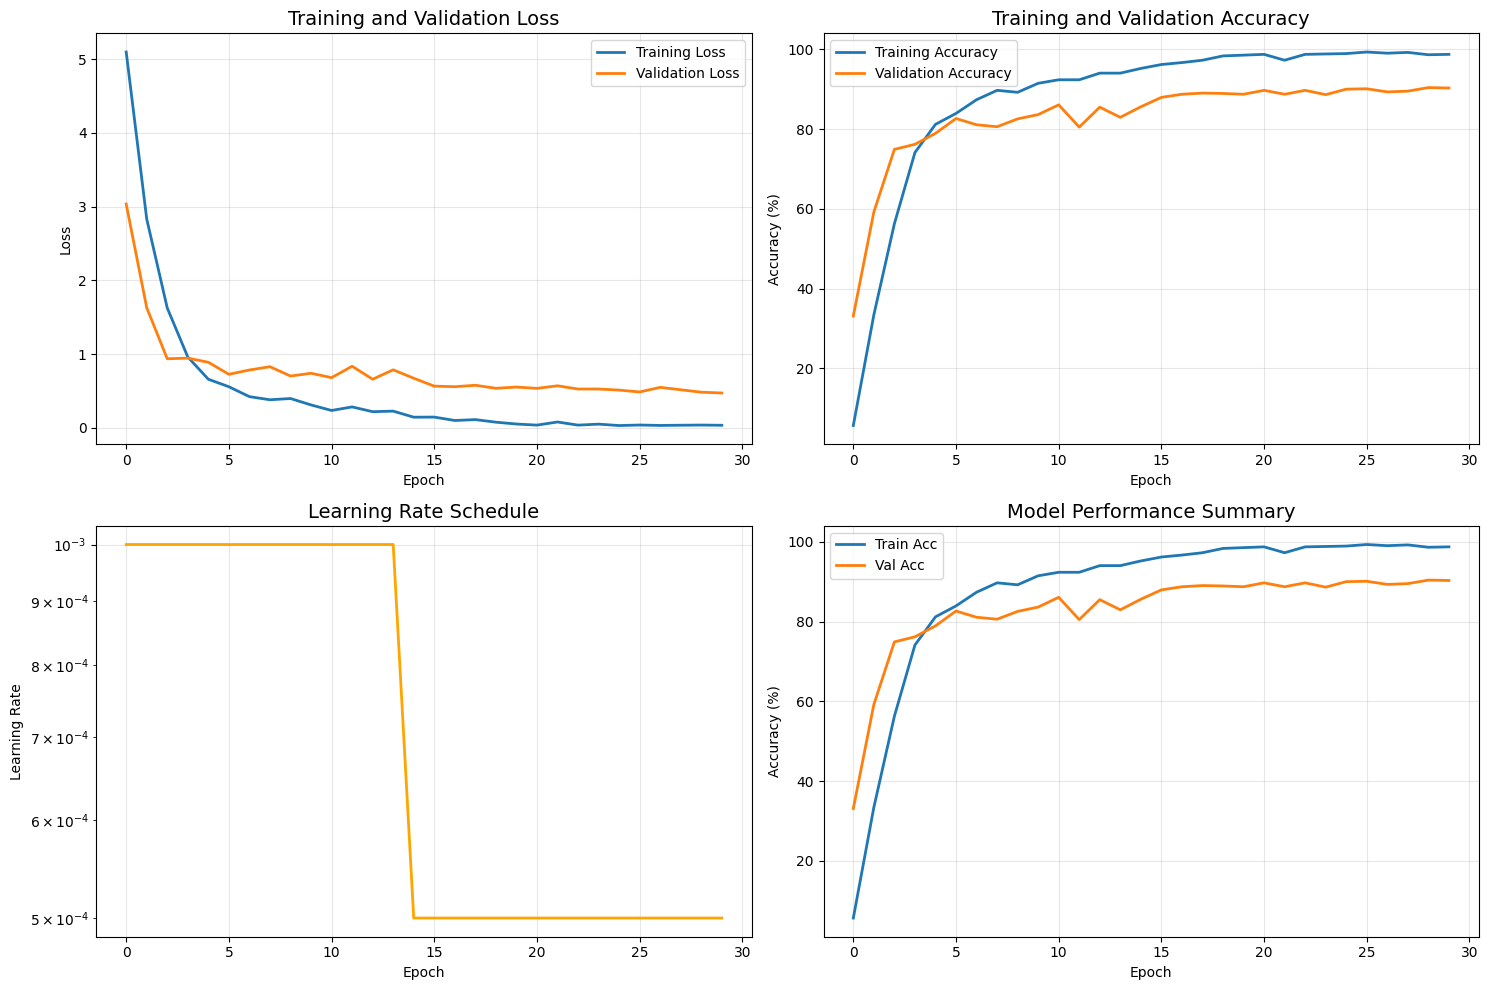

Saving training history to /content/drive/MyDrive/flower_recognition/training_history.json...
Training history saved!
Training curves displayed and history saved!


In [25]:
# Plot training curves to visualize model performance over epochs
fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create a figure with a 2x2 grid of subplots

# --- Loss curves ---
# Plot training loss over epochs
axes[0, 0].plot(history['train_loss'], label='Training Loss', linewidth=2)
# Plot validation loss over epochs
axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- Accuracy curves ---
# Plot training accuracy over epochs
axes[0, 1].plot(history['train_acc'], label='Training Accuracy', linewidth=2)
# Plot validation accuracy over epochs
axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- Learning rate curve ---
# Plot learning rate changes over epochs (due to scheduler)
axes[1, 0].plot(history['learning_rates'], linewidth=2, color='orange')
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log') # Use a logarithmic scale for better visualization of LR changes
axes[1, 0].grid(True, alpha=0.3)

# --- Combined performance metrics ---
# Plot training and validation accuracy again for a summary view
axes[1, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1, 1].set_title('Model Performance Summary', fontsize=14)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout() # Adjust layout to prevent overlapping elements
plt.show() # Display the generated plots

# Save the complete training history to a JSON file
print(f"Saving training history to {os.path.join(WORK_DIR, 'training_history.json')}...")
with open(os.path.join(WORK_DIR, 'training_history.json'), 'w') as f:
    json.dump(history, f, indent=2)
print("Training history saved!")
print("Training curves displayed and history saved!")

In [30]:
# --- Model Evaluation on Test Set ---

# Load the best performing model checkpoint based on validation accuracy
print(f"Loading best model from {os.path.join(WORK_DIR, 'best_model.pth')} for evaluation...")
checkpoint = torch.load(os.path.join(WORK_DIR, 'best_model.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with validation accuracy {checkpoint['val_acc']:.2f}%")

# Set the model to evaluation mode
model.eval()

# Initialize lists to store all predictions and true labels from the test set
all_predictions = []
all_targets = []

print("Evaluating on test set...")
# Disable gradient calculation for inference
with torch.no_grad():
    # Iterate through the test data loader
    for data, targets in tqdm(test_loader, desc="Testing"):
        data, targets = data.to(device), targets.to(device) # Move data and labels to the device
        outputs = model(data) # Perform forward pass
        _, predicted = torch.max(outputs, 1) # Get predicted class with highest probability

        # Store predictions and true labels (move to CPU and convert to numpy)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate overall test accuracy
test_accuracy = accuracy_score(all_targets, all_predictions)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions, target_names=class_names))
unique_labels_in_test = np.unique(all_targets)


Loading best model from /content/drive/MyDrive/flower_recognition/best_model.pth for evaluation...
Loaded best model from epoch 29 with validation accuracy 90.39%
Evaluating on test set...


Testing: 100%|██████████| 193/193 [00:51<00:00,  3.74it/s]


Test Accuracy: 0.8790 (87.90%)

Classification Report:
                           precision    recall  f1-score   support

            pink primrose       0.62      0.90      0.73        20
hard-leaved pocket orchid       0.97      0.97      0.97        40
         canterbury bells       0.43      0.45      0.44        20
                sweet pea       0.69      0.50      0.58        36
         english marigold       0.78      0.89      0.83        45
               tiger lily       1.00      0.92      0.96        25
              moon orchid       0.76      0.95      0.84        20
         bird of paradise       0.85      0.97      0.91        65
                monkshood       0.71      0.85      0.77        26
            globe thistle       0.96      1.00      0.98        25
               snapdragon       0.79      0.67      0.73        67
              colt's foot       0.97      0.96      0.96        67
              king protea       0.97      1.00      0.98        29
     

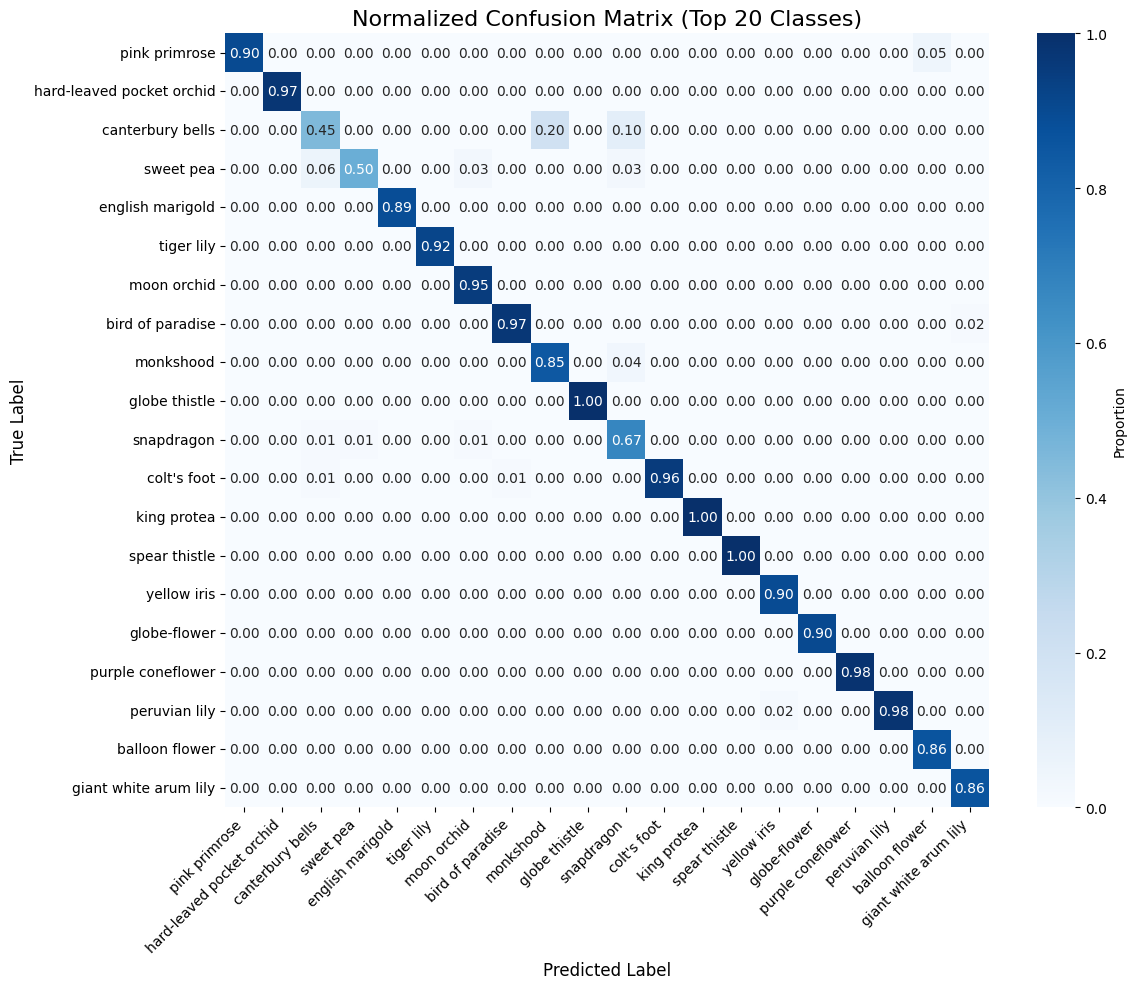

Confusion matrix displayed!


In [27]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_targets, all_predictions)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix (top 20 classes for clarity)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized[:20, :20],
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names[:20],
    yticklabels=class_names[:20],
    cbar_kws={'label': 'Proportion'}
)

plt.title('Normalized Confusion Matrix (Top 20 Classes)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Confusion matrix displayed!")

In [28]:
# Save class names
with open(os.path.join(WORK_DIR, 'class_names.json'), 'w') as f:
    json.dump(class_names, f, indent=2)

# Create deployment-ready model (without optimizer state)
deployment_model = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'num_classes': 102,
        'model_type': 'efficientnet_b0',
        'input_size': [3, 224, 224]
    },
    'class_names': class_names,
    'training_info': {
        'best_val_accuracy': best_val_acc,
        'test_accuracy': test_accuracy,
        'best_epoch': best_epoch,
        'total_epochs_trained': num_epochs
    }
}

# Save deployment model
torch.save(deployment_model, os.path.join(WORK_DIR, 'flower_model.pth'))

print(f"Model saved for deployment!")
print(f"Files saved in: {WORK_DIR}")
print(f"- best_model.pth (training checkpoint)")
print(f"- flower_model.pth (deployment model)")
print(f"- class_names.json")
print(f"- training_history.json")
print(f"- evaluation_results.json")

# Display file sizes
import os
for filename in ['best_model.pth', 'flower_model.pth', 'class_names.json']:
    filepath = os.path.join(WORK_DIR, filename)
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / 1024 / 1024
        print(f"- {filename}: {size_mb:.1f} MB")

Model saved for deployment!
Files saved in: /content/drive/MyDrive/flower_recognition
- best_model.pth (training checkpoint)
- flower_model.pth (deployment model)
- class_names.json
- training_history.json
- evaluation_results.json
- best_model.pth: 54.4 MB
- flower_model.pth: 18.3 MB
- class_names.json: 0.0 MB


In [33]:
# Print final summary
print("=" * 60)
print("🌸 FLOWER RECOGNITION MODEL TRAINING COMPLETE 🌸")
print("=" * 60)
print(f"\n📊 Performance Summary:")
print(f"   • Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"   • Test Accuracy: {(test_accuracy*100):.2f}%")
print(f"   • Best Epoch: {best_epoch}/{num_epochs}")
print(f"   • Model Size: ~{total_params * 4 / 1024 / 1024:.1f} MB")

print(f"\n📁 Files Created:")
print(f"   • flower_model.pth - Deployment-ready model")
print(f"   • class_names.json - Flower class names")
print(f"   • training_history.json - Training metrics")
print(f"   • evaluation_results.json - Test results")

if IN_COLAB:
    print(f"\n💾 Google Drive Location:")
    print(f"   • {WORK_DIR}")
    print(f"\n📥 To download files:")
    print(f"   1. Open Google Drive")
    print(f"   2. Navigate to 'My Drive > flower_recognition'")
    print(f"   3. Download the files")
else:
    print(f"\n💾 Local Location:")
    print(f"   • {WORK_DIR}")

print(f"\n🚀 Next Steps for Deployment:")
print(f"   1. Download flower_model.pth and class_names.json")
print(f"   2. Place them in your project directory")
print(f"   3. Update the FastAPI app to use the new model")
print(f"   4. Run: python main.py")

print("\n" + "=" * 60)
print("🎉 Training completed successfully! 🎉")
print("=" * 60)

🌸 FLOWER RECOGNITION MODEL TRAINING COMPLETE 🌸

📊 Performance Summary:
   • Best Validation Accuracy: 90.39%
   • Test Accuracy: 87.90%
   • Best Epoch: 29/30
   • Model Size: ~18.0 MB

📁 Files Created:
   • flower_model.pth - Deployment-ready model
   • class_names.json - Flower class names
   • training_history.json - Training metrics
   • evaluation_results.json - Test results

💾 Google Drive Location:
   • /content/drive/MyDrive/flower_recognition

📥 To download files:
   1. Open Google Drive
   2. Navigate to 'My Drive > flower_recognition'
   3. Download the files

🚀 Next Steps for Deployment:
   1. Download flower_model.pth and class_names.json
   2. Place them in your project directory
   3. Update the FastAPI app to use the new model
   4. Run: python main.py

🎉 Training completed successfully! 🎉
